
# DATS 2102 · Week 11 — Uncertainty & Error Visualization

This notebook demonstrates techniques for **communicating uncertainty** using the **Boston Housing** dataset.  
By default, it tries to load `MASS::Boston` via `statsmodels`; if that isn't available (e.g., offline), it falls back to a **simulated Boston-like** sample with the same key variables (`rm`, `lstat`, `medv`).

- Libraries: Seaborn, Matplotlib, Plotly.  
- Altair code is included as an **optional** cell.


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import statsmodels.api as sm
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import numpy as np, pandas as pd

# Enable Altair rendering in notebooks (choose one that fits your environment)
# alt.renderers.enable('default')  # Jupyter
# alt.renderers.enable('mimetype') # VS Code
# alt.data_transformers.disable_max_rows()  # if you hit row limits

sns.set_theme(style="whitegrid")


In [2]:
boston = sm.datasets.get_rdataset("Boston", "MASS").data
df = boston.rename(columns=str.lower)

## 1. Seaborn: Mean ± 95% CI by binned `rm`

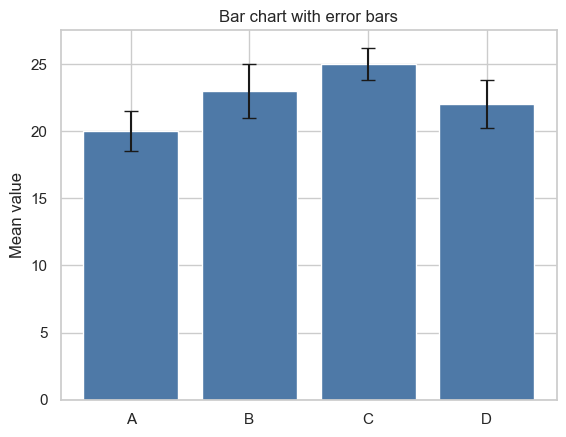

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulated means and standard errors
groups = ['A','B','C','D']
means = [20, 23, 25, 22]
se = [1.5, 2.0, 1.2, 1.8]

plt.bar(groups, means, yerr=se, capsize=5, color='#4e79a7')
plt.title('Bar chart with error bars')
plt.ylabel('Mean value')
plt.show()

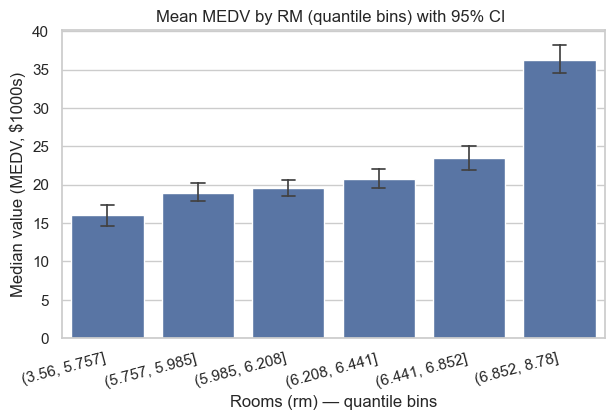

In [5]:

df1 = df.copy()
df1["rm_bin"] = pd.qcut(df1["rm"], q=6, duplicates="drop")

plt.figure(figsize=(7,4))
sns.barplot(data=df1, x="rm_bin", y="medv", errorbar=('ci', 95), capsize=.15, err_kws={'linewidth': 1.25})
plt.xticks(rotation=15, ha="right")
plt.title(f"Mean MEDV by RM (quantile bins) with 95% CI ")
plt.xlabel("Rooms (rm) — quantile bins")
plt.ylabel("Median value (MEDV, $1000s)")
plt.show()


## 2. Seaborn: Regression with Confidence Band

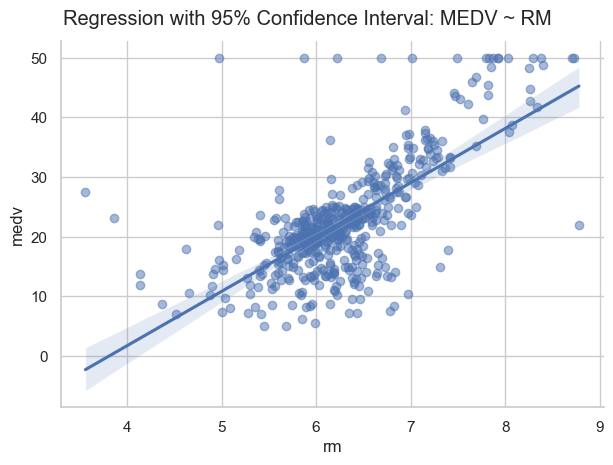

In [21]:
g = sns.lmplot(data=df, x="rm", y="medv", height=4.5, aspect=1.4, ci=95, scatter_kws={"alpha":0.5})
g.fig.suptitle(f"Regression with 95% Confidence Interval: MEDV ~ RM", y=1.03)
plt.show()



## 3. Altair (Optional): Layered Regression with 95% CI

> To run this section, install Altair + converter:  
> `pip install altair vl-convert-python`


In [ ]:
pip install altair vl-convert-python

In [22]:
import altair as alt
import pandas as pd
# alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')  # Jupyter
# alt.renderers.enable('mimetype') # VS Code

base = alt.Chart(df).mark_point(opacity=0.4).encode(
    x=alt.X('rm', title='Average Rooms per Dwelling (rm)'),
    y=alt.Y('medv', title='Median Value ($1000s, medv)'),
    tooltip=['rm','medv']
)

reg_line = alt.Chart(df).transform_regression('rm','medv').mark_line(color='red', size=2)

(base + reg_line).properties(
    title='Altair: Regression Line (no CI — older Altair)',
    width=500, height=300
)



alt.LayerChart(...)

In [24]:
import numpy as np
import pandas as pd
import altair as alt

alt.data_transformers.disable_max_rows()

# Bootstrap a linear fit to get a CI band, independent of Altair version
rng = np.random.default_rng(0)
xs = np.linspace(df['rm'].min(), df['rm'].max(), 250)
B = 600  # number of bootstrap resamples

preds = np.empty((B, xs.size))
for b in range(B):
    sample = df.sample(len(df), replace=True, random_state=b)
    # simple linear fit y = a*rm + b
    a, b0 = np.polyfit(sample['rm'].values, sample['medv'].values, 1)
    preds[b, :] = a*xs + b0

band = pd.DataFrame({
    'rm': xs,
    'y_mean': preds.mean(axis=0),
    'y_low':  np.percentile(preds, 2.5, axis=0),
    'y_high': np.percentile(preds, 97.5, axis=0)
})

points = alt.Chart(df).mark_point(opacity=0.35).encode(
    x=alt.X('rm', title='Average Rooms per Dwelling (rm)'),
    y=alt.Y('medv', title='Median Value ($1000s, medv)'),
    tooltip=['rm','medv']
)

band_area = alt.Chart(band).mark_area(opacity=0.25).encode(
    x='rm',
    y='y_low',
    y2='y_high'
)

mean_line = alt.Chart(band).mark_line(color='red', size=2).encode(
    x='rm',
    y='y_mean'
)

(points + band_area + mean_line).properties(
    title='Altair: Regression with 95% Bootstrap CI (version-agnostic)',
    width=500, height=300
)


alt.LayerChart(...)

## Box / Violin plots — distribution spread by binned `rm`

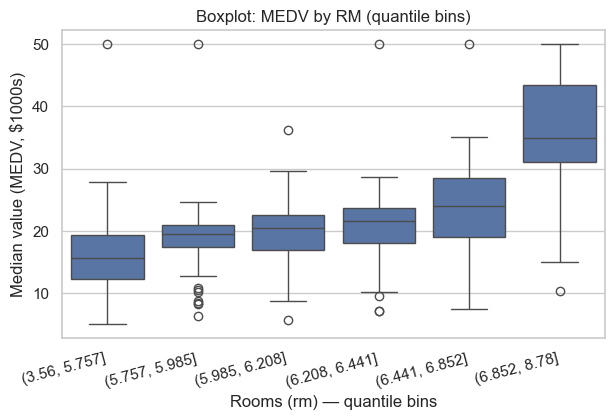

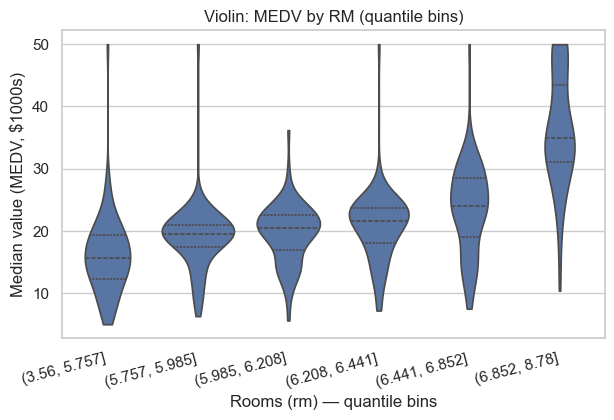

In [30]:

plt.figure(figsize=(7,4))
sns.boxplot(data=df1, x="rm_bin", y="medv")
plt.xticks(rotation=15, ha="right")
plt.title(f"Boxplot: MEDV by RM (quantile bins)")
plt.xlabel("Rooms (rm) — quantile bins")
plt.ylabel("Median value (MEDV, $1000s)")
plt.show()

plt.figure(figsize=(7,4))
sns.violinplot(data=df1, x="rm_bin", y="medv", inner="quartile", cut=0)
plt.xticks(rotation=15, ha="right")
plt.title(f"Violin: MEDV by RM (quantile bins)")
plt.xlabel("Rooms (rm) — quantile bins")
plt.ylabel("Median value (MEDV, $1000s)")
plt.show()


## Density curves & rug plots — `medv`

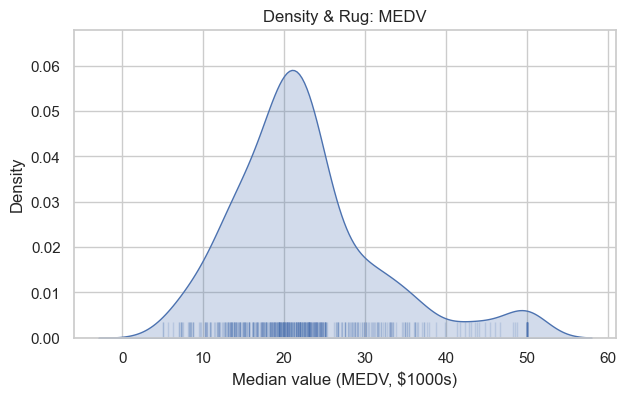

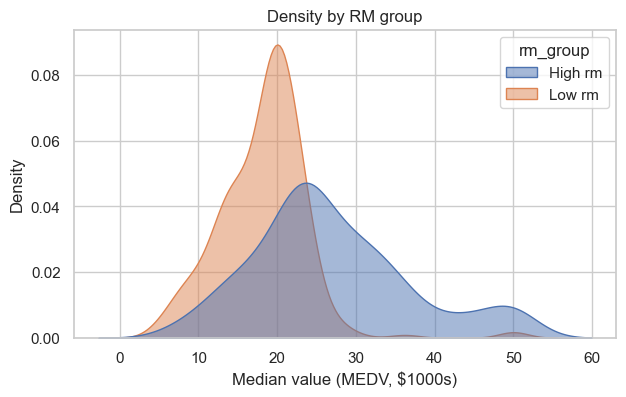

In [31]:

plt.figure(figsize=(7,4))
sns.kdeplot(data=df, x="medv", fill=True)
sns.rugplot(data=df, x="medv", alpha=0.2, height=0.05)
plt.title(f"Density & Rug: MEDV")
plt.xlabel("Median value (MEDV, $1000s)")
plt.ylabel("Density")
plt.show()

median_rm = df["rm"].median()
df["rm_group"] = np.where(df["rm"] >= median_rm, "High rm", "Low rm")
plt.figure(figsize=(7,4))
sns.kdeplot(data=df, x="medv", hue="rm_group", fill=True, common_norm=False, alpha=0.5)
plt.title(f"Density by RM group")
plt.xlabel("Median value (MEDV, $1000s)")
plt.ylabel("Density")
plt.show()

## Opacity to suggest imprecision — alpha encodes uncertainty / density

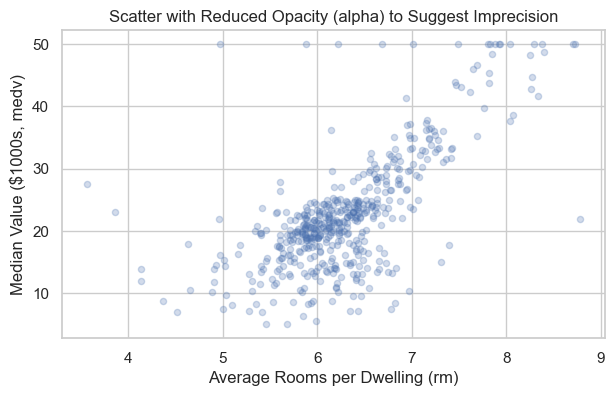

In [32]:
plt.figure(figsize=(7,4))
plt.scatter(df["rm"], df["medv"], alpha=0.25, s=20)
plt.title(f"Scatter with Reduced Opacity (alpha) to Suggest Imprecision")
plt.xlabel("Average Rooms per Dwelling (rm)")
plt.ylabel("Median Value ($1000s, medv)")
plt.show()

## Bootstrap: Distribution of Mean MEDV

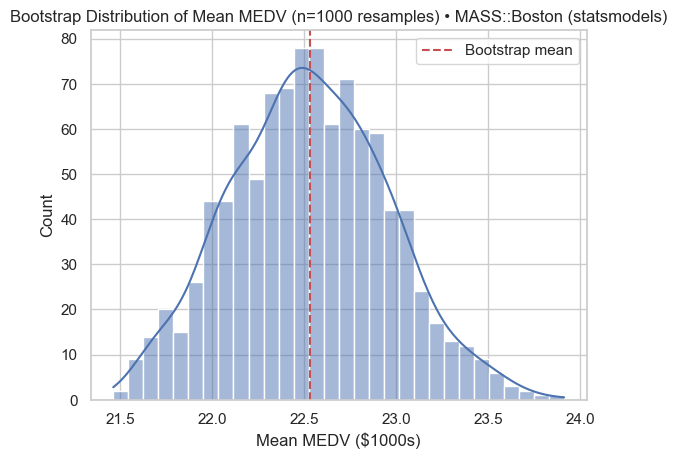

In [16]:

means = []
for i in range(1000):
    sample = resample(df["medv"], random_state=i)
    means.append(sample.mean())

sns.histplot(means, kde=True, bins=30)
plt.axvline(np.mean(means), color='r', linestyle='--', label="Bootstrap mean")
plt.title(f"Bootstrap Distribution of Mean MEDV (n=1000 resamples) • {data_source}")
plt.xlabel("Mean MEDV ($1000s)")
plt.legend()
plt.show()


## 5. Plotly: Ensemble 'Spaghetti' of Bootstrap Fits (MEDV ~ RM)

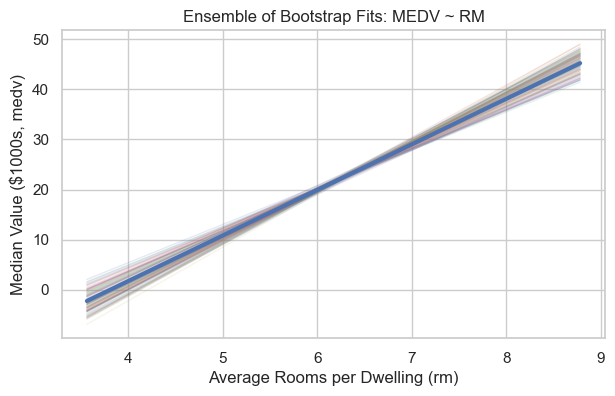

In [34]:

X = df[["rm"]].values
y = df["medv"].values
xs = np.linspace(df["rm"].min(), df["rm"].max(), 150).reshape(-1,1)

plt.figure(figsize=(7,4))
for i in range(100):
    idx = np.random.choice(len(df), size=len(df), replace=True)
    Xi = X[idx]
    yi = y[idx]
    lr = LinearRegression().fit(Xi, yi)
    yhat = lr.predict(xs)
    plt.plot(xs, yhat, lw=1, alpha=0.15)
# Add mean fit
lr_full = LinearRegression().fit(X, y)
yhat_full = lr_full.predict(xs)
plt.plot(xs, yhat_full, lw=3)
plt.title(f"Ensemble of Bootstrap Fits: MEDV ~ RM")
plt.xlabel("Average Rooms per Dwelling (rm)")
plt.ylabel("Median Value ($1000s, medv)")
plt.show()


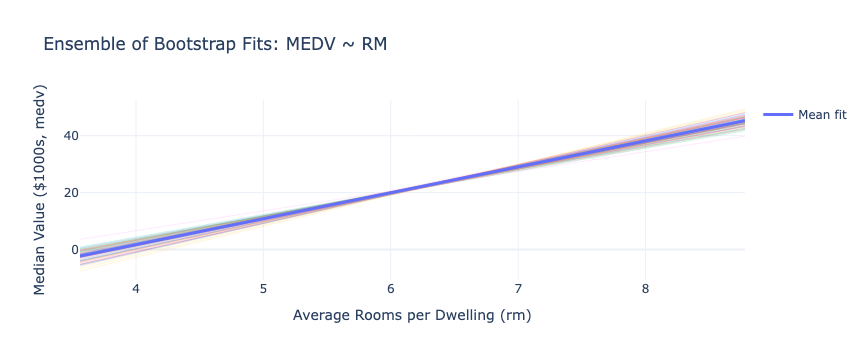

In [26]:

import numpy as np
from sklearn.linear_model import LinearRegression

X = df[["rm"]].values
y = df["medv"].values
xs = np.linspace(df["rm"].min(), df["rm"].max(), 150).reshape(-1,1)

import plotly.graph_objects as go
fig = go.Figure()
for i in range(80):
    idx = np.random.choice(len(df), size=len(df), replace=True)
    Xi = X[idx]
    yi = y[idx]
    lr = LinearRegression().fit(Xi, yi)
    yhat = lr.predict(xs)
    fig.add_trace(go.Scatter(x=xs.flatten(), y=yhat, mode='lines', line=dict(width=1), opacity=0.2, showlegend=False))

lr_full = LinearRegression().fit(X, y)
yhat_full = lr_full.predict(xs)
fig.add_trace(go.Scatter(x=xs.flatten(), y=yhat_full, mode='lines', line=dict(width=3), name='Mean fit'))

fig.update_layout(title=f"Ensemble of Bootstrap Fits: MEDV ~ RM",
                  xaxis_title="Average Rooms per Dwelling (rm)",
                  yaxis_title="Median Value ($1000s, medv)",
                  template="plotly_white")
fig



### Key Takeaways
- Always **quantify** uncertainty (state SD, SE, 95% CI, credible interval, etc.).  
- Use **shading/opacity** for bands; avoid clutter and overplotting.  
- **Bootstrap** intervals often communicate sampling variability effectively.  
- Interactivity (Altair/Plotly) helps audiences **explore** uncertainty.
